In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

from ds_utils.db.connectors import PivotDW

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', True)

# pd.set_option('precision', 2)

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.style.use('fivethirtyeight')


# pd.option_context('display.max_rows', None, 'display.max_columns', None)

print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [6]:
# This is a query on a materialized view.  Refresh once a day.
refresh_view = False

stm_query = """
    SELECT
        date_part(MONTH, datetime_created)::INT AS sold_month,
        CASE 
            WHEN duration_sold < 135 THEN '90'
            WHEN duration_sold BETWEEN 135 AND 264 THEN '180'
            WHEN duration_sold BETWEEN 265 AND 364 THEN '364'
            WHEN duration_sold > 364 THEN '364+'
            ELSE null END AS plan_group,
        count(1) AS policies
    FROM tracking.app_premium_revised
    WHERE date_part(YEAR, datetime_created)::INT = 2020
        AND product_type = 'STM'
    GROUP BY 1,2
    ;
"""

with PivotDW() as db_context:

        
    df = db_context.to_df(stm_query, parse_dates='sold_date')


print(len(df))
df.head()


INFO:root:query: SELECT date_part(MONTH, datetime_created)::INT AS sold_month... executed in 9.52 seconds


49


,sold_month,plan_group,policies
0,10,180,1153
1,11,364+,532
2,5,364+,160
3,6,364+,157
4,9,364+,190


<AxesSubplot:xlabel='sold_month'>

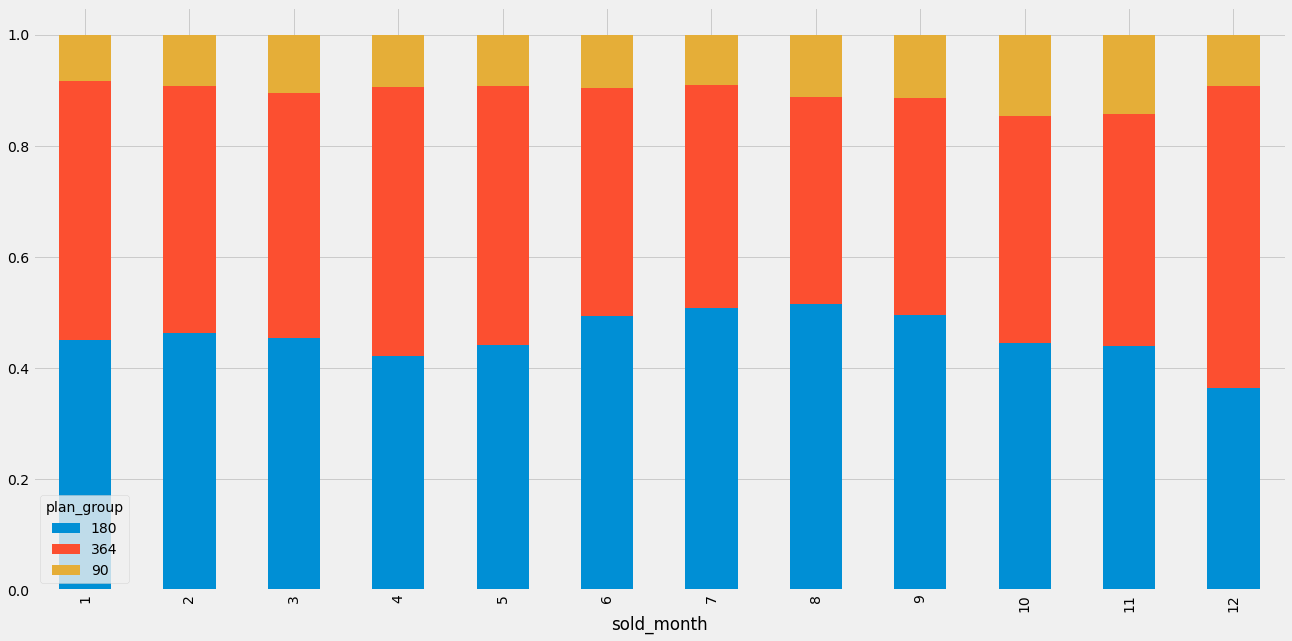

In [33]:
slice_df = df[df['plan_group'].isin(['90','180','364'])]


group_df = slice_df.pivot_table(index='sold_month', columns='plan_group', values='policies')
month_df = slice_df.groupby('sold_month')[['policies']].sum()
month_df = month_df.reset_index().copy().rename(columns={'policies': 'month_total'})
combined_df = slice_df.merge(month_df, how='inner', on='sold_month')

combined_df['policy_share'] = combined_df['policies'] / combined_df['month_total']

combined_df.pivot_table(index='sold_month', columns='plan_group', values='policy_share').plot\
    .bar(stacked=True, figsize=(20,10))